# Named-Entity Recognition
Implementation of a LSTM NER tagger following the paper _Neural Architectures for Named Entity Recognition_ from 2016 by Lample, Ballesteros, Subramanian, Kawakami, and Dyer.

Author: Pierre Nugues

## A note on the performance

Guillaume Lample used Theano and Python 2, and his code is available here: https://github.com/glample/tagger. Lample et .al reported a F1 performance of 89.15 without conditional random fields (CRF) and 90.94 with CRF.

Here, I used Keras and Python 3, and I set aside the CRF layer as the official Keras does not support any implementation of it. The available CRF layers I tested were quite brittle and may not survive future Keras and Tensorflow evolutions. This implementation has a few other differences with the original one: For instance, Lample et .al used skip-n-grams, while I used Glove.

I set the hyperparameters following two papers by Reimers and Gurevych (2017):
* _Reporting Score Distributions Makes a Difference: Performance Study of LSTM-networks for Sequence Tagging_ in Proc. of EMNLP, where they obtained a median performance of 90.81, slightly lower than the one reported by Lample's and al. (http://aclweb.org/anthology/D17-1035);
* _Optimal Hyperparameters for Deep LSTM-Networks for Sequence Labeling Tasks_, where they quantify the influence of parameters from a collection of 50,000 runs. Paper: https://arxiv.org/abs/1707.06799 and code: https://github.com/UKPLab/emnlp2017-bilstm-cnn-crf.

I took the parameters that had most influence and that only required an option change in Keras.

## Imports

In [1]:
import regex as re
import numpy as np
import statistics
import random
import matplotlib.pyplot as plt
from sklearn import base
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Embedding, Dense, Dropout, TimeDistributed, concatenate
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.optimizers import Nadam
# from tf2crf import CRF, ModelWithCRFLoss
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from tqdm import tqdm


EPOCHS = 100
CHAR_LSTM_UNITS = 25
LSTM_UNITS = 100
EMBEDDING_DIM = 100
CHAR_EMBEDDING_DIM = 25
RAND_INIT_RANGE = 0.05
PROB_SUBST = 0.5
BATCH_SIZE = 32
PATIENCE = 15
BINS = True
LOWER = True    # Tells if the words will be lowercased or not. 
                # This should match the embeddings case. We do not lowercase the character input

# Defaults
MAX_SENT_LEN_TRAIN = 150
MAX_SENT_LEN_DEV = 150
MAX_SENT_LEN_TEST = 150
MAX_WORD_LEN_TRAIN = 30
MAX_WORD_LEN_DEV = 30
MAX_WORD_LEN_TEST = 30

COLAB = False

## Collecting a Dataset

1. We use the CoNLL dataset on named entity recognition. There were two conferences on it: <a href="https://www.clips.uantwerpen.be/conll2002/ner/">CoNLL 2002</a> (Spanish and Dutch) and <a href="https://www.clips.uantwerpen.be/conll2003/ner/">CoNLL 2003</a> (English and German). We work here work on the English dataset.
3. The dataset comes in the form of three files: a training set, a development set, and a test set. <!--, named:
    <tt>eng.train</tt>, <tt>eng.testa</tt> (validation), and <tt>eng.testb</tt> (test).-->

In [2]:
if COLAB:
    from google.colab import drive
    drive.mount("/content/drive")
    EMBEDDING_DIR = '/content/drive/My Drive/Colab Notebooks/corpus/'
    EMBEDDING_FILE = 'glove.6B.100d.txt'
    BASE_DIR = '/content/drive/My Drive/Colab Notebooks/corpus/'
    RESULTS_DIR = '/content/drive/My Drive/Colab Notebooks/'
    MODELS_DIR = '/content/drive/My Drive/Colab Notebooks/'
else:
    EMBEDDING_DIR = '/Users/pierre/Documents/Cours/EDAN20/corpus/'
    EMBEDDING_FILE = 'glove.6B.100d.txt'
    BASE_DIR = '/Users/pierre/Projets/Corpora/CoNLL2003/'
    RESULTS_DIR = '/Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/results/'
    MODELS_DIR = '/Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/'

## Reading the Corpus

We read the corpus with the cells below. The functions will enable us to load the files in the form of a list of dictionaries.

In [3]:
def load_conll2003_en():
    #train_file = BASE_DIR + 'NER-data/eng.train'
    #dev_file = BASE_DIR + 'NER-data/eng.valid'
    #test_file = BASE_DIR + 'NER-data/eng.test'
    train_file = BASE_DIR + 'ner-bio/train.txt'
    dev_file = BASE_DIR + 'ner-bio/valid.txt'
    test_file = BASE_DIR + 'ner-bio/test.txt'    
    column_names = ['form', 'ppos', 'pchunk', 'ner']
    train_sentences = open(train_file, encoding='utf8').read().strip()
    dev_sentences = open(dev_file, encoding='utf8').read().strip()
    test_sentences = open(test_file, encoding='utf8').read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

In [4]:
train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en()
train_sentences[:100]

'-DOCSTART- -X- -X- O\n\nEU NNP B-NP B-ORG\nrejects VBZ B-VP O\nGerman JJ B-NP B-MISC\ncall NN I-NP O\nto T'

In [5]:
class Token(dict):
    pass


class CoNLLDictorizer(base.TransformerMixin):

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

In [6]:
conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)

In [7]:
print(train_dict[0])
print('\n'.join(map(str, train_dict[1])))

[{'form': '-DOCSTART-', 'ppos': '-X-', 'pchunk': '-X-', 'ner': 'O'}]
{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-ORG'}
{'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'B-VP', 'ner': 'O'}
{'form': 'German', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}
{'form': 'call', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}
{'form': 'to', 'ppos': 'TO', 'pchunk': 'B-VP', 'ner': 'O'}
{'form': 'boycott', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O'}
{'form': 'British', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}
{'form': 'lamb', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}
{'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}


## Evaluating the Models

We will train the models with the training set and use the test set to evaluate them. For this, we will apply the `conlleval` script that will compute the harmonic mean of the precision and recall: F1. 

`conlleval` was written in Perl. Some people rewrote it in Python and we use the translation here. The line below installs it.

In [8]:
!pip install conlleval
import conlleval

## Collecting the Embeddings

We will represent the words with the GloVe embeddings:
1. We download the GloVe embeddings 6B from <a href="https://nlp.stanford.edu/projects/glove/">https://nlp.stanford.edu/projects/glove/</a> and keep the 100d vectors.
2. We apply a function that reads GloVe embeddings and store them in a dictionary, where the keys will be the words and the values, the embeddings.

In [9]:
def read_embeddings(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    glove = open(file, encoding='utf8')
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embeddings[word] = vector
    glove.close()
    return embeddings

In [10]:
# We read the embeddings
embedding_file = EMBEDDING_DIR + EMBEDDING_FILE
embeddings_dict = read_embeddings(embedding_file)
embedded_words = sorted(list(embeddings_dict.keys()))
print('# words in embedding dictionary:', len(embedded_words))

# words in embedding dictionary: 400000


In [11]:
max([len(embeddings_dict[word]) for word in embeddings_dict.keys()])

100

## Extracting the $\mathbf{X}$ and $\mathbf{Y}$ Lists of Symbols

We use a `build_sequences(corpus_dict, key_x='form', key_y='ner', tolower=True)` function that for each sentence returns the $\mathbf{x}$ and $\mathbf{y}$ lists of symbols consisting of words and NER tags.

In [12]:
def build_sequences(corpus_dict, key_x='form', key_y='pos', tolower=True):
    """
    Creates sequences from a list of dictionaries
    :param corpus_dict:
    :param key_x:
    :param key_y:
    :return:
    """
    X = []
    Y = []
    for sentence in corpus_dict:
        x = [word[key_x] for word in sentence]
        y = [word[key_y] for word in sentence]
        if tolower:
            x = list(map(str.lower, x))
        X += [x]
        Y += [y]
    return X, Y

In [13]:
X_train_word_cat, Y_train_cat = build_sequences(train_dict, key_x='form', key_y='ner', tolower=False)
X_dev_word_cat, Y_dev_cat = build_sequences(dev_dict, key_x='form', key_y='ner', tolower=False)
X_test_word_cat, Y_test_cat = build_sequences(test_dict, key_x='form', key_y='ner', tolower=False)

In [14]:
print('First sentence, word input', X_train_word_cat[1])
print('First sentence, NER output', Y_train_cat[1])

First sentence, word input ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
First sentence, NER output ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


## Extracting the $\mathbf{X}$ Symbols

### Vocabulary from CoNLL

In [15]:
# We collect the words in their original case from the three sets
vocabulary_words_train = tuple([word
                          for sentence in X_train_word_cat
                          for word in sentence])
vocabulary_words_dev = tuple([word
                        for sentence in X_dev_word_cat
                        for word in sentence])
vocabulary_words_test = tuple([word
                         for sentence in X_test_word_cat
                         for word in sentence])

In [16]:
# We extract the unique words in their original case
#vocabulary_words_conll = list(vocabulary_words_train)
vocabulary_words_conll = tuple(sorted(list(set(vocabulary_words_train))))
print('#words:', len(vocabulary_words_conll))

#words: 23624


### Singletons

Lample et al. use the singletons to train the embeddings of the unknown word symbol. We extract them here.

In [17]:
# We extract the singletons
if LOWER:
    counts = Counter(map(str.lower, list(vocabulary_words_train)))
else:
    counts= Counter(vocabulary_words_train)
singletons = [k for k, v in counts.items() if counts[k] == 1]
len(singletons)

10060

### Characters from CoNLL

In [18]:
# We collect all the unique characters in their original case
chars = set(''.join(vocabulary_words_conll))
chars = tuple(sorted(list(chars)))

In [19]:
NB_CHARS = len(chars)
print('#chars:', NB_CHARS)

#chars: 84


### Stats on the the word lengths

Maximal length of a word, mean, and reasonable upperbound of a word length. Not used in the rest of the program.

In [20]:
MAX_WORD_LEN = max([len(word) for word in vocabulary_words_conll])
print('Word maximal length', MAX_WORD_LEN)

Word maximal length 61


In [21]:
statistics.mean([len(word) for word in vocabulary_words_conll])

6.832839485269218

In [22]:
statistics.mean([len(word) for word in vocabulary_words_conll]) + 3 * statistics.stdev(
    [len(word) for word in vocabulary_words_conll])

15.080759869694724

### Vocabulary from CoNLL and the Embeddings

We create a vocabulary of all the words observed in the training set and the words in the pretrained embeddings. We merge the list of unique CoNLL words with the words in the embedding file and we sort them. We store the vocabulary in `vocabulary_words`.

We align the case the CoNLL words with the embeddings

In [23]:
if LOWER:
    vocabulary_words = set(map(str.lower, vocabulary_words_conll))
else:
    vocabulary_words = set(vocabulary_words_conll)
print('# unique (possibly lowercased) words in the CoNLL vocabulary:',
      len(vocabulary_words))

# unique (possibly lowercased) words in the CoNLL vocabulary: 21010


In [24]:
# Adding vocabulary of embedded words
vocabulary_words = tuple(sorted(list(set(embedded_words + list(vocabulary_words)))))

In [25]:
print('# words in the vocabulary: embeddings and CoNLL corpus:', len(vocabulary_words))

# words in the vocabulary: embeddings and CoNLL corpus: 402595


## Extracting the $\mathbf{Y}$ Symbols

In [26]:
ner = tuple(sorted(set([ner
                  for sentence in Y_train_cat
                  for ner in sentence])))
NB_CLASSES = len(ner)
print(NB_CLASSES, 'named entity tags:', ner)

9 named entity tags: ('B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O')


## Characters, Words, and NER Indices

We create the indices `word2idx`, `ner2idx` and inverted indices `idx2word`, `idx2ner` for the words and the NER. We use index 0 for the padding symbol and 1 for unknown words.

In [27]:
# We create the indexes
# For the words and chars, we start at two to make provision for
# the padding symbol 0 in RNN and LSTMs and unknown words/chars, 1
# We do not need it for the outpout
idx2char = dict(enumerate(chars, start=2))
idx2word = dict(enumerate(vocabulary_words, start=2))
idx2ner = dict(enumerate(ner, start=0))
char2idx = {v: k for k, v in idx2char.items()}
word2idx = {v: k for k, v in idx2word.items()}
ner2idx = {v: k for k, v in idx2ner.items()}

In [28]:
print('char index:', list(char2idx.items())[:10])
print('word index:', list(word2idx.items())[:10])
print('NER index:', list(ner2idx.items()))

char index: [('!', 2), ('"', 3), ('$', 4), ('%', 5), ('&', 6), ("'", 7), ('(', 8), (')', 9), ('*', 10), ('+', 11)]
word index: [('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!?', 7), ('!?!', 8), ('"', 9), ('#', 10), ('##', 11)]
NER index: [('B-LOC', 0), ('B-MISC', 1), ('B-ORG', 2), ('B-PER', 3), ('I-LOC', 4), ('I-MISC', 5), ('I-ORG', 6), ('I-PER', 7), ('O', 8)]


## Creating the $\mathbf{X}$ and $\mathbf{Y}$ Sequences

We now create the input and output sequences with numerical indices. First, we convert the $\mathbf{X}$ and $\mathbf{Y}$ lists of symbols in lists of numbers using the indices we created

### The Chararacters

In [29]:
def to_char_index(X, idx, UKN_IDX=1):
    """
    Convert the word lists (or POS lists) to char indexes
    :param X: List of word (or POS) lists
    :param idx: char to number dictionary
    :return: A list of x, where x is a list of char lists
    """
    X_idx = []
    for xl in X:
        # We map the unknown symbols to one
        x_idx = [list(map(lambda x: idx.get(x, UKN_IDX), list(x))) for x in xl]
        X_idx += [x_idx]
    return X_idx

In [30]:
# We create the parallel sequences of indexes for the chars in their original case
X_train_char_idx = to_char_index(X_train_word_cat, char2idx)
X_dev_char_idx = to_char_index(X_dev_word_cat, char2idx)
X_test_char_idx = to_char_index(X_test_word_cat, char2idx)

In [31]:
X_train_word_cat[:2]

[['-DOCSTART-'],
 ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']]

In [32]:
X_train_char_idx[:2]

[[[13, 34, 45, 33, 49, 50, 31, 48, 50, 13]],
 [[35, 51],
  [77, 64, 69, 64, 62, 79, 78],
  [37, 64, 77, 72, 60, 73],
  [62, 60, 71, 71],
  [79, 74],
  [61, 74, 84, 62, 74, 79, 79],
  [32, 77, 68, 79, 68, 78, 67],
  [71, 60, 72, 61],
  [14]]]

### The Words

In [33]:
# We set the words in lower case.
if LOWER:
    X_train_word_cat = [[x.lower() for x in x_vect] for x_vect in X_train_word_cat]
    X_dev_word_cat = [[x.lower() for x in x_vect] for x_vect in X_dev_word_cat]
    X_test_word_cat = [[x.lower() for x in x_vect] for x_vect in X_test_word_cat]

In [34]:
X_train_word_cat[1]

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']

In [35]:
def to_index(X, idx, UKN_IDX=1):
    """
    Convert the word lists (or POS lists) to indexes
    :param X: List of word (or POS) lists
    :param idx: word to number dictionary
    :return:
    """
    X_idx = []
    for x in X:
        # We map the unknown symbols to one
        x_idx = list(map(lambda x: idx.get(x, UKN_IDX), x))
        X_idx += [x_idx]
    return X_idx

In [36]:
# We create the parallel sequences of indexes for the words
# Train
X_train_word_idx = to_index(X_train_word_cat, word2idx)
# Dev
X_dev_word_idx = to_index(X_dev_word_cat, word2idx)
# Test
X_test_word_idx = to_index(X_test_word_cat, word2idx)

In [37]:
print('Train. Word indices:', X_train_word_idx[:2])
print('Dev. Word indices:', X_dev_word_idx[:2])
print('Test. Word indices:', X_test_word_idx[:2])

Train. Word indices: [[935], [142143, 307143, 161836, 91321, 363368, 83766, 85852, 218260, 936]]
Dev. Word indices: [[935], [113351, 679, 221875, 354360, 275584, 63471, 364505, 49150, 192163, 381011, 936]]
Test. Word indices: [[935], [338644, 679, 197600, 162137, 229067, 390518, 517, 100680, 190291, 350949, 120818, 936]]


### The NER Tags

In [38]:
# Train
Y_train_idx = to_index(Y_train_cat, ner2idx)
# Dev
Y_dev_idx = to_index(Y_dev_cat, ner2idx)
# Test
Y_test_idx = to_index(Y_test_cat, ner2idx)

In [39]:
print('Train. NER indices:', Y_train_idx[:2])
print('Dev. NER indices:', Y_dev_idx[:2])
print('Test. NER indices:', Y_test_idx[:2])

Train. NER indices: [[8], [2, 8, 1, 8, 8, 8, 1, 8, 8]]
Dev. NER indices: [[8], [8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8]]
Test. NER indices: [[8], [8, 8, 0, 8, 8, 8, 8, 3, 8, 8, 8, 8]]


## Padding

### Characters

We first pad the characters of a word to have a a length of `MAX_WORD_LEN`. We compute it for each set.

In [40]:
MAX_WORD_LEN_TRAIN = max([len(word)  for sentence in X_train_char_idx for word in sentence])
MAX_WORD_LEN_DEV = max([len(word)  for sentence in X_dev_char_idx for word in sentence])
MAX_WORD_LEN_TEST = max([len(word)  for sentence in X_test_char_idx for word in sentence])

In [41]:
X_train_char_idx = list(map(lambda x: pad_sequences(x, maxlen=MAX_WORD_LEN_TRAIN, padding='post'),
                            X_train_char_idx))
X_dev_char_idx = list(map(lambda x: pad_sequences(x, maxlen=MAX_WORD_LEN_DEV, padding='post'),
                          X_dev_char_idx))
X_test_char_idx = list(map(lambda x: pad_sequences(x, maxlen=MAX_WORD_LEN_TEST, padding='post'),
                           X_test_char_idx))

In [42]:
X_train_char_idx[:2]

[array([[13, 34, 45, 33, 49, 50, 31, 48, 50, 13,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32),
 array([[35, 51,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [77, 64, 69, 64, 62, 79, 78,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [37, 64, 77, 72, 60, 73,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

We then pad the lists of lists of characters to have a length of `MAX_SENT_LEN_TRAIN`. We determine it for each set.

In [43]:
MAX_SENT_LEN_TRAIN = max(map(len, X_train_word_idx))
MAX_SENT_LEN_DEV = max(map(len, X_dev_word_idx))
MAX_SENT_LEN_TEST = max(map(len, X_test_word_idx))

In [44]:
#X_train_char_idx = pad_sequences(X_train_char_idx, maxlen=MAX_SENT_LEN_TRAIN, padding='post')
X_dev_char_idx = pad_sequences(X_dev_char_idx, maxlen=MAX_SENT_LEN_DEV, padding='post')
X_test_char_idx = pad_sequences(X_test_char_idx, maxlen=MAX_SENT_LEN_TEST, padding='post')

In [45]:
X_train_char_idx[:2]

[array([[13, 34, 45, 33, 49, 50, 31, 48, 50, 13,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32),
 array([[35, 51,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [77, 64, 69, 64, 62, 79, 78,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [37, 64, 77, 72, 60, 73,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

### Words

We pad the word lists. Here we only pad the dev and test set to be able to predict in one go.

In [46]:
#X_train_word_idx = pad_sequences(X_train_word_idx, maxlen=MAX_SENT_LEN_TRAIN, padding='post')
X_dev_word_idx = pad_sequences(X_dev_word_idx, maxlen=MAX_SENT_LEN_DEV, padding='post')
X_test_word_idx = pad_sequences(X_test_word_idx, maxlen=MAX_SENT_LEN_TEST, padding='post')

In [47]:
X_train_word_idx[:2]

[[935], [142143, 307143, 161836, 91321, 363368, 83766, 85852, 218260, 936]]

We pad the NER lists

In [48]:
#Y_train_idx = pad_sequences(Y_train_idx, maxlen=MAX_SENT_LEN_TRAIN, padding='post')
Y_dev_idx = pad_sequences(Y_dev_idx, maxlen=MAX_SENT_LEN_DEV, padding='post')
Y_test_idx = pad_sequences(Y_test_idx, maxlen=MAX_SENT_LEN_TEST, padding='post')

In [49]:
Y_train_idx[:2]

[[8], [2, 8, 1, 8, 8, 8, 1, 8, 8]]

## Padding the training set

Depending on the training procedure, we need to pad or not the training set:
1. If we use `fit`, we have to pad;
2. We can also create bins of same length and train with `train_on_batch`. This allows for a more flexible training loop.

In [50]:
if not BINS:
    X_train_char_idx = pad_sequences(X_train_char_idx, maxlen=MAX_SENT_LEN_TRAIN, padding='post')
    X_train_word_idx = pad_sequences(X_train_word_idx, maxlen=MAX_SENT_LEN_TRAIN, padding='post')
    Y_train_idx = pad_sequences(Y_train_idx, maxlen=MAX_SENT_LEN_TRAIN, padding='post')  
training_bins = [list(zip(X_train_word_idx, X_train_char_idx, Y_train_idx))]

## Creating bins of same length

We create bins of sentences of the same length. This avoids padding

In [51]:
if BINS:
    training_set_sorted = sorted(zip(X_train_word_idx, 
                           X_train_char_idx, 
                           Y_train_idx), 
                       key=lambda x: len(x[0]))

We now create the histogram of sentence lengths. `groupby` is like the `uniq -c` shell command. We obtain a list of pairs: (sentence length, count of sentences that have this length)

In [52]:
from itertools import groupby
if BINS:
    train_sent_len_list = list(map(lambda x: len(x[0]), training_set_sorted))
    train_length_hist = [(x[0], len(list(x[1]))) for x in groupby(train_sent_len_list)]
    train_length_hist[:10]

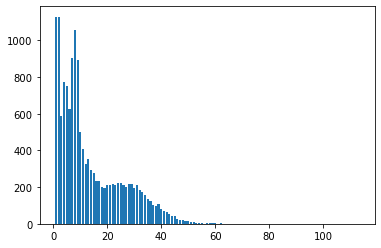

In [53]:
if BINS:
    plt.bar(list(map(lambda x: x[0], train_length_hist)),
        list(map(lambda x: x[1], train_length_hist)))

We create the bins

In [54]:
if BINS:
    training_bins = []
    for bin in train_length_hist:
        training_bins += [training_set_sorted[:bin[1]]]
        training_set_sorted = training_set_sorted[bin[1]:]

We print a few sentences of two words

In [55]:
if BINS:
    for i in range(5):
        print(training_bins[1][i])

([284434, 79019], array([[46, 64, 79, 64, 77,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [32, 71, 60, 62, 70, 61, 80, 77, 73,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32), [3, 7])
([86920, 15423], array([[32, 48, 51, 49, 49, 35, 42, 49,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [17, 25, 25, 22, 13, 16, 24, 13, 18, 18,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,

## Embedding Matrix

Create a matrix of dimensions $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in GloVe, and $N$, the dimension of the embeddings.
The padding symbol and the unknown word symbol will be part of the vocabulary. The shape of your matrix should be: (402597, 100). Initialize it with random values.

In [56]:
np.random.seed(0)
# We add two dimensions for the padding symbol at index 0 and unknown words at index 1
embedding_matrix = np.random.uniform(-0.05, 0.05, (len(vocabulary_words) + 2, EMBEDDING_DIM))
# embedding_matrix = np.random.random((len(vocabulary_words) + 2, EMBEDDING_DIM))
# embedding_matrix = np.zeros((len(vocabulary_words) + 2, EMBEDDING_DIM))

In [57]:
print('Shape of embedding matrix:', embedding_matrix.shape)

Shape of embedding matrix: (402597, 100)


Fill the matrix with the GloVe embeddings when available. You will use the indices from the previous section. You will call `out_of_embeddings` the list of words in CoNLL, but not in the embedding list.

In [58]:
out_of_embeddings = []
for word in vocabulary_words:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_matrix[word2idx[word]] = embeddings_dict[word]
    else:
        # Otherwise, it keeps a random value in the matrix
        # We store the out of vocabulary words
        out_of_embeddings += [word]

In [59]:
print('Out of embeddings:', len(out_of_embeddings))
out_of_embeddings[-10:]

Out of embeddings: 2595


['zelezarny',
 'zhilan',
 'zieger',
 'zighayer',
 'zilinskiene',
 'zirka-nibas',
 'zuleeg',
 'zundra',
 'zwingmann',
 'zyrecha']

In [60]:
print('Embedding of the padding symbol, idx 0, random numbers', embedding_matrix[0][:10])
print('Embedding of table', embedding_matrix[word2idx['table']][:10])
if LOWER:
    print('Embedding of zwingmann, random numbers', embedding_matrix[word2idx['zwingmann']][:10])
else:
    print('Embedding of Zwingmann, random numbers', embedding_matrix[word2idx['Zwingmann']][:10])

Embedding of the padding symbol, idx 0, random numbers [ 0.00488135  0.02151894  0.01027634  0.00448832 -0.00763452  0.01458941
 -0.00624128  0.0391773   0.04636628 -0.01165585]
Embedding of table [-0.61453998  0.89692998  0.56770998  0.39102    -0.22437     0.49035001
  0.10868     0.27410999 -0.23833001 -0.52152997]
Embedding of zwingmann, random numbers [ 0.00782644 -0.02621394  0.04756559  0.00408949  0.01875676  0.01106755
  0.01659441  0.02207432 -0.03631456  0.00730187]


## A LSTM Network

In [61]:
#char input
# shape: (MAX_SENT_LEN, MAX_WORD_LEN,)
char_input = Input(shape=(None, None,))
embedded_chars = Embedding(input_dim=NB_CHARS + 2,
                                 output_dim=CHAR_EMBEDDING_DIM,
                                 trainable=True,
                                 mask_zero=True,
                                 embeddings_initializer=RandomUniform(minval=-RAND_INIT_RANGE,
                                                                      maxval=RAND_INIT_RANGE))(char_input)
encoded_chars = TimeDistributed(Bidirectional(LSTM(CHAR_LSTM_UNITS, return_sequences=False)))(embedded_chars)

In [62]:
# word input
# shape: (MAX_SENT_LEN,)
word_input = Input(shape=(None,))
embedded_words = Embedding(len(vocabulary_words) + 2,
                           EMBEDDING_DIM,
                           trainable=True,
                           mask_zero=True,
                           weights=[embedding_matrix])(word_input)

In [63]:
# concatenation
final_embeddings = concatenate([encoded_chars, embedded_words])

In [64]:
# dropout
final_embeddings = Dropout(0.5)(final_embeddings)

In [65]:
lstm_output = Bidirectional(LSTM(LSTM_UNITS,
                                 recurrent_dropout=0.5,
                                 return_sequences=True))(final_embeddings)
"""lstm_output = Dropout(0.5)(lstm_output)
lstm_output = Bidirectional(LSTM(LSTM_UNITS,
                                 recurrent_dropout=0.5,
                                 return_sequences=True))(lstm_output)"""
out = Dense(len(ner), activation='softmax')(lstm_output)

In [66]:
model = Model([char_input, word_input], out)

Compile it

In [67]:
opt = Nadam(clipnorm=1.0)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None)] 0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, None, 2 2150        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 50)     10200       embedding[0][0]                  
______________________________________________________________________________________________

## Function to save the results

The columns of an annotated corpus: We add `pner`

In [68]:
ann_column_names = ['form', 'ppos', 'pchunk', 'ner', 'pner']

In [69]:
def dict2conll(corpus_dict, column_names):
    """
    Saves the corpus in a file
    :param file:
    :param corpus_dict:
    :param column_names:
    :return:
    """
    corpus_str = ''
    for sentence in corpus_dict:
        sentence_lst = []
        for row in sentence:
            items = map(lambda x: row.get(x, '_'), column_names)
            sentence_lst += ' '.join(items) + '\n'
        sentence_lst += '\n'
        sentence_str = ''.join(sentence_lst)
        corpus_str += sentence_str
    return corpus_str

## Training the model

In [70]:
def minibatch_generator(dataset):
    # We take the sentences of the same length
    random.shuffle(dataset)
    for sentence_bin in dataset:
        random.shuffle(sentence_bin)
        # The number of batches. 
        batch_cnt = int(np.ceil((len(sentence_bin) / BATCH_SIZE)))
        # We create batches of BATCH_SIZE
        for j in range(batch_cnt):
            char_batch = []
            token_batch = []
            label_batch = []
            for sentence in sentence_bin[j*BATCH_SIZE:(j+1)*BATCH_SIZE]:
                tokens, chars, labels = sentence
                char_batch.append(chars)
                token_batch.append(tokens)
                label_batch.append(labels)
            #label_batch = list(map(lambda x: np.transpose([x]), label_batch))
            #label_batch = to_categorical(label_batch, num_classes=len(ner))
            yield  np.asarray(char_batch), np.asarray(token_batch), np.asarray(label_batch)

In [71]:
dev_scores = []
test_scores = []
for epoch in tqdm(range(EPOCHS)):
    print("Epoch {}/{}".format(epoch + 1, EPOCHS))
    for i, batch in enumerate(minibatch_generator(training_bins)):
        char_batch, token_batch, label_batch = batch
        # Symbol substitution to train the unknown word embedding
        new_token_batch = []
        for i, sentence in enumerate(token_batch):
            new_token_batch += [[1 if idx_word != 0 and counts[idx2word[idx_word]] == 1 and np.random.uniform() < PROB_SUBST
                                 else idx_word for idx_word in sentence]]
        new_token_batch = np.array(new_token_batch)
        loss = model.train_on_batch([char_batch, new_token_batch],
                                    label_batch)

    # We evaluate the dev set
    print('CoNLL score dev set')
    Y_dev_hat = model.predict([X_dev_char_idx, X_dev_word_idx])
    for sent, y_probs_hat in zip(dev_dict, Y_dev_hat):
        sent_len = len(sent)
        y_probs_hat = y_probs_hat[:sent_len]
        y_hat = map(np.argmax, y_probs_hat)
        for word, ner_hat in zip(sent, y_hat):
            word['pner'] = idx2ner[ner_hat]
    conll_str = dict2conll(dev_dict, ann_column_names)

    outfile = RESULTS_DIR + 'dev.out'
    with open(outfile, 'w', encoding='utf8') as f_out:
        f_out.write(conll_str)
    lines = open(outfile, encoding='utf8').read().splitlines()
    res = conlleval.evaluate(lines)
    dev_score = res['overall']['chunks']['evals']['f1']
    dev_scores += [dev_score] 
    print('dev', dev_score, flush=True)
       
    # We evaluate the test set
    print('CoNLL score test set')
    Y_test_hat = model.predict([X_test_char_idx, X_test_word_idx])
    for sent, y_probs_hat in zip(test_dict, Y_test_hat):
        sent_len = len(sent)
        y_probs_hat = y_probs_hat[:sent_len]
        y_hat = map(np.argmax, y_probs_hat)
        for word, ner_hat in zip(sent, y_hat):
            word['pner'] = idx2ner[ner_hat]
    conll_str = dict2conll(test_dict, ann_column_names)

    outfile = RESULTS_DIR + 'test.out'
    with open(outfile, 'w', encoding='utf8') as f_out:
        f_out.write(conll_str)
    lines = open(outfile, encoding='utf8').read().splitlines()
    res = conlleval.evaluate(lines)
    test_score = res['overall']['chunks']['evals']['f1']
    test_scores += [test_score]
    print('test', test_score, flush=True)
    
    if dev_score == max(dev_scores):
        model.save(MODELS_DIR)
    
    if max(dev_scores) > max(dev_scores[-PATIENCE - 1:]):
        break

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100
CoNLL score dev set
dev 0.8038553422851963
CoNLL score test set
test 0.7711464147702877


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
  1%|          | 1/100 [03:00<4:58:17, 180.78s/it]

Epoch 2/100
CoNLL score dev set
dev 0.8543385021445068
CoNLL score test set
test 0.8381282495667244


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
  2%|▏         | 2/100 [05:47<4:41:48, 172.53s/it]

Epoch 3/100
CoNLL score dev set
dev 0.8761857214178732
CoNLL score test set
test 0.8514540214828399


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
  3%|▎         | 3/100 [08:34<4:34:57, 170.08s/it]

Epoch 4/100
CoNLL score dev set
dev 0.8821286472148542
CoNLL score test set
test 0.8573660908064936


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
  4%|▍         | 4/100 [11:23<4:31:29, 169.68s/it]

Epoch 5/100
CoNLL score dev set
dev 0.8940253671562083
CoNLL score test set
test 0.8711484593837536


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
  5%|▌         | 5/100 [14:07<4:25:28, 167.66s/it]

Epoch 6/100
CoNLL score dev set
dev 0.9025162472921181
CoNLL score test set
test 0.8702010968921389


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
  6%|▌         | 6/100 [16:49<4:19:15, 165.48s/it]

Epoch 7/100
CoNLL score dev set
dev 0.907185628742515
CoNLL score test set
test 0.8708551483420593


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
  7%|▋         | 7/100 [19:19<4:09:04, 160.69s/it]

Epoch 8/100
CoNLL score dev set
dev 0.9144434222631095
CoNLL score test set
test 0.8759839076438692


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
  8%|▊         | 8/100 [21:59<4:05:54, 160.37s/it]

Epoch 9/100
CoNLL score dev set
dev 0.9148438804474871
CoNLL score test set
test 0.8821212916776057


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
  9%|▉         | 9/100 [24:44<4:05:22, 161.79s/it]

Epoch 10/100
CoNLL score dev set
dev 0.9183724621940013
CoNLL score test set
test 0.8800070120080639


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 10%|█         | 10/100 [27:24<4:01:42, 161.14s/it]

Epoch 11/100
CoNLL score dev set
dev 0.9194574681848627
CoNLL score test set
test 0.8800561551285426


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 11%|█         | 11/100 [30:08<4:00:25, 162.08s/it]

Epoch 12/100
CoNLL score dev set
dev 0.9221757322175732
CoNLL score test set
test 0.8834151472650771


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 12%|█▏        | 12/100 [32:52<3:58:25, 162.57s/it]

Epoch 13/100
CoNLL score dev set
dev 0.9215571368773545
CoNLL score test set
test 0.8826315789473684


 13%|█▎        | 13/100 [35:21<3:49:55, 158.57s/it]

Epoch 14/100
CoNLL score dev set
dev 0.9173408958211694
CoNLL score test set
test 0.8822859146288018


 14%|█▍        | 14/100 [37:45<3:41:05, 154.25s/it]

Epoch 15/100
CoNLL score dev set
dev 0.9191851728168309
CoNLL score test set
test 0.8749344978165938


 15%|█▌        | 15/100 [40:13<3:35:44, 152.29s/it]

Epoch 16/100
CoNLL score dev set
dev 0.9240780911062907
CoNLL score test set
test 0.8824914943732007


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 16%|█▌        | 16/100 [42:51<3:35:29, 153.92s/it]

Epoch 17/100
CoNLL score dev set
dev 0.9221136989732032
CoNLL score test set
test 0.8806087641039098


 17%|█▋        | 17/100 [45:16<3:29:15, 151.27s/it]

Epoch 18/100
CoNLL score dev set
dev 0.9251507032819826
CoNLL score test set
test 0.8936319718928416


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 18%|█▊        | 18/100 [47:58<3:31:09, 154.51s/it]

Epoch 19/100
CoNLL score dev set
dev 0.9257620041753654
CoNLL score test set
test 0.8837941897094854


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 19%|█▉        | 19/100 [50:33<3:28:54, 154.75s/it]

Epoch 20/100
CoNLL score dev set
dev 0.9278471465683399
CoNLL score test set
test 0.8907636874945074


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 20%|██        | 20/100 [53:11<3:27:36, 155.71s/it]

Epoch 21/100
CoNLL score dev set
dev 0.9279211559341852
CoNLL score test set
test 0.8850514564800279


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 21%|██        | 21/100 [55:48<3:25:18, 155.93s/it]

Epoch 22/100
CoNLL score dev set
dev 0.9270450751252086
CoNLL score test set
test 0.8837046745303626


 22%|██▏       | 22/100 [58:18<3:20:29, 154.22s/it]

Epoch 23/100
CoNLL score dev set
dev 0.9296268469822189
CoNLL score test set
test 0.8893166506256016


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 23%|██▎       | 23/100 [1:01:09<3:24:30, 159.36s/it]

Epoch 24/100
CoNLL score dev set
dev 0.9277420432712389
CoNLL score test set
test 0.8918067226890756


 24%|██▍       | 24/100 [1:03:38<3:17:47, 156.15s/it]

Epoch 25/100
CoNLL score dev set
dev 0.9281111390074485
CoNLL score test set
test 0.8884791008078681


 25%|██▌       | 25/100 [1:06:05<3:11:57, 153.56s/it]

Epoch 26/100
CoNLL score dev set
dev 0.932352203361485
CoNLL score test set
test 0.8896297596069486


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 26%|██▌       | 26/100 [1:08:49<3:13:03, 156.53s/it]

Epoch 27/100
CoNLL score dev set
dev 0.9319056382800737
CoNLL score test set
test 0.8920080708834107


 27%|██▋       | 27/100 [1:11:21<3:08:54, 155.27s/it]

Epoch 28/100
CoNLL score dev set
dev 0.9221277305319326
CoNLL score test set
test 0.8812817369987742


 28%|██▊       | 28/100 [1:13:50<3:04:11, 153.49s/it]

Epoch 29/100
CoNLL score dev set
dev 0.9272651356993736
CoNLL score test set
test 0.8841442072103605


 29%|██▉       | 29/100 [1:16:07<2:55:46, 148.54s/it]

Epoch 30/100
CoNLL score dev set
dev 0.9303765690376569
CoNLL score test set
test 0.8902171046848906


 30%|███       | 30/100 [1:18:25<2:49:26, 145.23s/it]

Epoch 31/100
CoNLL score dev set
dev 0.9308871575772807
CoNLL score test set
test 0.8902567710165318


 31%|███       | 31/100 [1:20:41<2:43:56, 142.55s/it]

Epoch 32/100
CoNLL score dev set
dev 0.9310862673118637
CoNLL score test set
test 0.8926573426573428


 32%|███▏      | 32/100 [1:23:06<2:42:10, 143.10s/it]

Epoch 33/100
CoNLL score dev set
dev 0.9321977287909151
CoNLL score test set
test 0.8897052392198023


 33%|███▎      | 33/100 [1:25:34<2:41:32, 144.67s/it]

Epoch 34/100
CoNLL score dev set
dev 0.9290074420938206
CoNLL score test set
test 0.8937664618086041


 34%|███▍      | 34/100 [1:28:02<2:40:13, 145.65s/it]

Epoch 35/100
CoNLL score dev set
dev 0.9279211559341852
CoNLL score test set
test 0.8891811327371559


 35%|███▌      | 35/100 [1:30:30<2:38:34, 146.38s/it]

Epoch 36/100
CoNLL score dev set
dev 0.9273425755804243
CoNLL score test set
test 0.8901926444833625


 36%|███▌      | 36/100 [1:32:54<2:35:30, 145.80s/it]

Epoch 37/100
CoNLL score dev set
dev 0.928446188528012
CoNLL score test set
test 0.891846921797005


 37%|███▋      | 37/100 [1:35:25<2:34:29, 147.14s/it]

Epoch 38/100
CoNLL score dev set
dev 0.9257285595337218
CoNLL score test set
test 0.8836884387006636


 38%|███▊      | 38/100 [1:37:55<2:32:55, 147.99s/it]

Epoch 39/100
CoNLL score dev set
dev 0.9290419411323272
CoNLL score test set
test 0.8926820728291317


 39%|███▉      | 39/100 [1:40:23<2:30:39, 148.18s/it]

Epoch 40/100
CoNLL score dev set
dev 0.9291798897611491
CoNLL score test set
test 0.8938223938223938


 40%|████      | 40/100 [1:42:50<2:27:48, 147.81s/it]

Epoch 41/100
CoNLL score dev set
dev 0.9263316330796889
CoNLL score test set
test 0.8869595720424451


 41%|████      | 41/100 [1:45:18<2:25:14, 147.70s/it]

Epoch 42/100
CoNLL score dev set
dev 0.9283806343906511
CoNLL score test set
test 0.8897851819377467


 41%|████      | 41/100 [1:47:38<2:34:53, 157.52s/it]


In [72]:
np.argmax(dev_scores), max(dev_scores)

(25, 0.932352203361485)

In [73]:
np.argmax(test_scores), max(test_scores)

(39, 0.8938223938223938)

In [74]:
"""callback_lists = [
    EarlyStopping(
        monitor='val_acc',
        patience=PATIENCE,
        restore_best_weights=True
    )
]"""

"callback_lists = [\n    EarlyStopping(\n        monitor='val_acc',\n        patience=PATIENCE,\n        restore_best_weights=True\n    )\n]"

In [75]:
"""history = model.fit([X_train_char_idx, X_train_word_idx], Y_train, epochs=EPOCHS, verbose=2,
                    validation_data=([X_dev_char_idx, X_dev_word_idx], Y_dev),
                    callbacks=callback_lists)"""

'history = model.fit([X_train_char_idx, X_train_word_idx], Y_train, epochs=EPOCHS, verbose=2,\n                    validation_data=([X_dev_char_idx, X_dev_word_idx], Y_dev),\n                    callbacks=callback_lists)'

We create a figure to show the training and validation losses and accuracies and a possible overfit.

In [76]:
"""acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

plt.show()"""

"acc = history.history['acc']\nval_acc = history.history['val_acc']\nloss = history.history['loss']\nval_loss = history.history['val_loss']\n\nepochs = range(1, len(acc) + 1)\nplt.plot(epochs, acc, 'bo', label='Training accuracy')\nplt.plot(epochs, val_acc, 'b', label='Validation accuracy')\nplt.title('Training and validation accuracies')\nplt.legend()\n\nplt.figure()\nplt.plot(epochs, loss, 'bo', label='Training loss')\nplt.plot(epochs, val_loss, 'b', label='Validation loss')\nplt.title('Training and validation losses')\nplt.legend()\n\nplt.show()"

## Evaluating the System

We restore the best corpus

In [77]:
model = load_model(MODELS_DIR)

Predict the NER sequence

In [78]:
# We evaluate on all the test corpus
Y_test_hat = model.predict([X_test_char_idx, X_test_word_idx])

We predict one observation at a time to avoid padding. We could have a speed up with batches

In [79]:
"""Y_test_hat = []
for x_test_char_idx, x_test_word_idx in zip(X_test_char_idx, X_test_word_idx):
    y_pred_vect = model.predict([np.array([x_test_char_idx]), np.array([x_test_word_idx])])[0]
    Y_test_hat += [y_pred_vect]"""

'Y_test_hat = []\nfor x_test_char_idx, x_test_word_idx in zip(X_test_char_idx, X_test_word_idx):\n    y_pred_vect = model.predict([np.array([x_test_char_idx]), np.array([x_test_word_idx])])[0]\n    Y_test_hat += [y_pred_vect]'

Extract the indices of the highest probabilities from the lists and convert them into NER values. Add them with the `pner` key to the dictionaries in the `test_dict` list.

In [80]:
test_dict[1]

[{'form': 'SOCCER', 'ppos': 'NN', 'pchunk': 'B-NP', 'ner': 'O', 'pner': 'O'},
 {'form': '-', 'ppos': ':', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'},
 {'form': 'JAPAN',
  'ppos': 'NNP',
  'pchunk': 'B-NP',
  'ner': 'B-LOC',
  'pner': 'B-LOC'},
 {'form': 'GET', 'ppos': 'VB', 'pchunk': 'B-VP', 'ner': 'O', 'pner': 'O'},
 {'form': 'LUCKY', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'O', 'pner': 'O'},
 {'form': 'WIN', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': ',', 'ppos': ',', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'},
 {'form': 'CHINA',
  'ppos': 'NNP',
  'pchunk': 'B-NP',
  'ner': 'B-PER',
  'pner': 'B-LOC'},
 {'form': 'IN', 'ppos': 'IN', 'pchunk': 'B-PP', 'ner': 'O', 'pner': 'O'},
 {'form': 'SURPRISE', 'ppos': 'DT', 'pchunk': 'B-NP', 'ner': 'O', 'pner': 'O'},
 {'form': 'DEFEAT', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'}]

In [81]:
Y_test_hat[1][:5]

array([[7.05878094e-08, 1.10734639e-07, 2.85347340e-07, 1.22164261e-08,
        3.98279854e-10, 1.56536771e-07, 8.59282157e-09, 5.59771918e-09,
        9.99999404e-01],
       [1.78205206e-09, 7.02660541e-10, 2.17378804e-09, 1.00219939e-08,
        7.94482169e-09, 1.19151524e-08, 4.67045922e-08, 2.90979987e-08,
        9.99999881e-01],
       [9.99826610e-01, 7.04344120e-06, 2.58498676e-06, 4.44017996e-06,
        5.23259644e-07, 1.51040469e-09, 3.09441228e-09, 4.42978348e-10,
        1.58823997e-04],
       [5.26873016e-08, 8.53360120e-07, 7.02723867e-07, 6.54960750e-05,
        1.86408684e-07, 1.51319352e-06, 4.16333819e-07, 6.30721900e-07,
        9.99930143e-01],
       [1.60824580e-04, 5.01741197e-05, 1.58358878e-03, 6.15130626e-02,
        1.96312328e-07, 9.41513235e-07, 4.84769907e-06, 1.36328545e-05,
        9.36672747e-01]], dtype=float32)

In [82]:
for sent, y_probs_hat in zip(test_dict, Y_test_hat):
    sent_len = len(sent)
    y_probs_hat = y_probs_hat[:sent_len]
    y_hat = map(np.argmax, y_probs_hat)
    for word, ner_hat in zip(sent, y_hat):
        word['pner'] = idx2ner[ner_hat]

In [83]:
test_dict[1]

[{'form': 'SOCCER', 'ppos': 'NN', 'pchunk': 'B-NP', 'ner': 'O', 'pner': 'O'},
 {'form': '-', 'ppos': ':', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'},
 {'form': 'JAPAN',
  'ppos': 'NNP',
  'pchunk': 'B-NP',
  'ner': 'B-LOC',
  'pner': 'B-LOC'},
 {'form': 'GET', 'ppos': 'VB', 'pchunk': 'B-VP', 'ner': 'O', 'pner': 'O'},
 {'form': 'LUCKY', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'O', 'pner': 'O'},
 {'form': 'WIN', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': ',', 'ppos': ',', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'},
 {'form': 'CHINA',
  'ppos': 'NNP',
  'pchunk': 'B-NP',
  'ner': 'B-PER',
  'pner': 'B-LOC'},
 {'form': 'IN', 'ppos': 'IN', 'pchunk': 'B-PP', 'ner': 'O', 'pner': 'O'},
 {'form': 'SURPRISE', 'ppos': 'DT', 'pchunk': 'B-NP', 'ner': 'O', 'pner': 'O'},
 {'form': 'DEFEAT', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'}]

## Saving the results

In [84]:
conll_str = dict2conll(test_dict, ann_column_names)

In [85]:
outfile = RESULTS_DIR + 'test.out'
with open(outfile, 'w', encoding='utf8') as f_out:
    f_out.write(conll_str)

In [86]:
lines = open(outfile, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
score = res['overall']['chunks']['evals']['f1']
score

0.8896297596069486

## Using the Recognizer to Tag a Sentence

A sentence

In [87]:
sentence = 'Yesterday , I met Pierre Nugues in Dammarie'

We create the character input

In [88]:
sent_char_idx = to_char_index([sentence.split()], char2idx)
MAX_WORD_LEN = max(map(len, sent_char_idx[0]))

In [89]:
sent_char_idx_padded = np.array(list(map(lambda x: pad_sequences(x, maxlen=MAX_WORD_LEN, padding='post'), 
                            sent_char_idx)))
sent_char_idx_padded

array([[[55, 64, 78, 79, 64, 77, 63, 60, 84],
        [12,  0,  0,  0,  0,  0,  0,  0,  0],
        [39,  0,  0,  0,  0,  0,  0,  0,  0],
        [72, 64, 79,  0,  0,  0,  0,  0,  0],
        [46, 68, 64, 77, 77, 64,  0,  0,  0],
        [44, 80, 66, 80, 64, 78,  0,  0,  0],
        [68, 73,  0,  0,  0,  0,  0,  0,  0],
        [34, 60, 72, 72, 60, 77, 68, 64,  0]]], dtype=int32)

And the word input

In [90]:
sent_word_idx = np.array(to_index([sentence.lower().split()], word2idx))
sent_word_idx

array([[396267,    517, 187251, 243996, 286609,      1, 190291,      1]])

And we predict the tags

In [91]:
y_probs_hat = model.predict([sent_char_idx_padded, sent_word_idx])

In [92]:
list(map(idx2ner.get, list(map(np.argmax, y_probs_hat[0]))[:len(sentence.split())]))

['O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'B-LOC']

## Experiments

Results on the test set using the model, where we reach a maximum on the dev set. Average on five consecutive runs.

One LSTM layer with the epoch number in comment.

In [93]:
runs = (0.8967934115997898, #59
0.8909569798068481, #89
0.8866736621196222, #43
0.8965456623011339, #51
0.8884221580467315) #51
sum(runs)/len(runs)

0.891878374774825

Two LSTM layers

In [95]:
## TODO